In [2]:
import os
import numpy as np
import cv2.cv2 as cv2

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
def RGB2YUV( rgb ):
     
    m = np.array([[ 0.29900, -0.16874,  0.50000],
                 [0.58700, -0.33126, -0.41869],
                 [ 0.11400, 0.50000, -0.08131]])
     
    yuv = np.dot(rgb,m)
    yuv[:,:,1:]+=128.0
    return yuv

def return_intersection(hist_1, hist_2):
    minima = np.minimum(hist_1, hist_2)
    intersection = np.true_divide(np.sum(minima), np.sum(hist_2))
    return intersection

def batch_hist(examples, channel):
    histograms = []
    for ex in examples:
        histr = cv2.calcHist([ex],[channel],None,[256],[-1,1])
        histograms.append(histr)
    histr = np.stack(histograms)
    histr = np.sum(histr, axis=0)
    return histr

In [4]:
examples = []
ycbcr_s = []
yuv_s = []
count = 0
folder = '/home/daniel/Pictures/imagenet_val'
for file in os.listdir(folder):
    if count >= 1000:
        break
    ex = cv2.imread(os.path.join(folder, file))
    if ex.shape[2] != 3:
        continue
    lab = cv2.cvtColor(ex, cv2.COLOR_BGR2LAB)
    
    lab = lab.astype('float32')
    lab /= 128.
    lab -= 1.
    examples.append(lab)
    
    ex_ycbcr = cv2.cvtColor(ex, cv2.COLOR_BGR2YCrCb)
    ex_ycbcr = ex_ycbcr.astype('float32')
    ex_ycbcr /= 128.
    ex_ycbcr -= 1.
    ycbcr_s.append(ex_ycbcr)
    
    ex_yuv = RGB2YUV(cv2.cvtColor(ex, cv2.COLOR_BGR2RGB))
    ex_yuv = ex_yuv.astype('float32')
    ex_yuv /= 128.
    ex_yuv -= 1.
    yuv_s.append(ex_yuv)
    
    count += 1

In [5]:
pixel_count = 0
for ex in examples:
    h, w, _ = ex.shape
    pixel_count += (h*w)


(256, 1)
(256, 1)


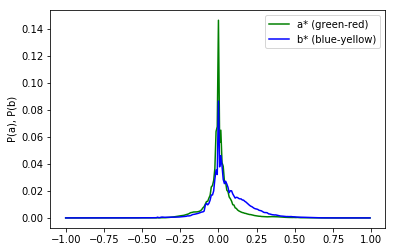

In [8]:
color = ('g','b')
gt_hist = []
for i,col in enumerate(color):
    histr = batch_hist(examples, i+1)
    print(histr.shape)
    #print(histr)
    histr /= pixel_count
    gt_hist.append(histr)
    plt.plot(np.arange(-1, 1, 2/256), histr, color = col)
    #plt.xlim([-1,1])
    
plt.ylabel('P(a), P(b)')
plt.legend(['a* (green-red)', 'b* (blue-yellow)'])
plt.savefig('histogram_Lab.png', dpi=144)
plt.show()

In [23]:
# load predictions

with open('pred_histogram_l2_b8.npy', 'rb') as file:
    pred_hist = np.load(file)

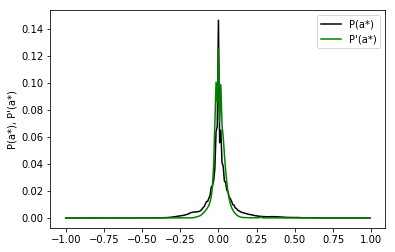

In [24]:
# Histogram intersection drawing 

# channel a
plt.plot(np.arange(-1, 1, 2/256), gt_hist[0], color = 'black')
plt.plot(np.arange(-1, 1, 2/256), pred_hist[0], color = 'g')
    
plt.ylabel('P(a*), P\'(a*)')
plt.legend(['P(a*)', 'P\'(a*)'])
plt.savefig('histogram_intersection_l2_b8_a.png', dpi=144)
plt.show()

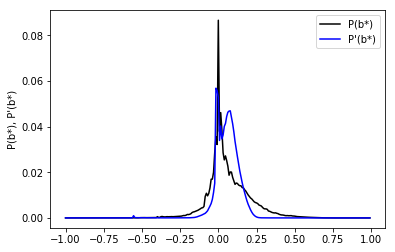

In [25]:
# Histogram intersection drawing 

# channel a
plt.plot(np.arange(-1, 1, 2/256), gt_hist[1], color = 'black')
plt.plot(np.arange(-1, 1, 2/256), pred_hist[1], color = 'b')
    
plt.ylabel('P(b*), P\'(b*)')
plt.legend(['P(b*)', 'P\'(b*)'])
plt.savefig('histogram_intersection_l2_b8_b.png', dpi=144)
plt.show()

**Histogram intersection**

$$K(a,b)=\frac{\sum_{i=1}^n\min (a_i,b_i)}{\min\left(\sum_i a_i,\sum_i b_i\right)}$$

In [12]:
def histogram_intersection(h1, h2):
    sum_of_mins = 0
    for i in range(h1.shape[0]):
        sum_of_mins += min(h1[i], h2[i])
    
    sum_h1 = np.sum(h1)
    sum_h2 = np.sum(h2)
    
    return sum_of_mins / min(sum_h1, sum_h2)    

In [13]:
inter_a = histogram_intersection(gt_hist[0], pred_hist[0])
inter_b = histogram_intersection(gt_hist[1], pred_hist[1])

print(f"Histogram intersection a: {inter_a}")
print(f"Histogram intersection b: {inter_b}")

Histogram intersection a: [0.63110673]
Histogram intersection b: [0.6477737]


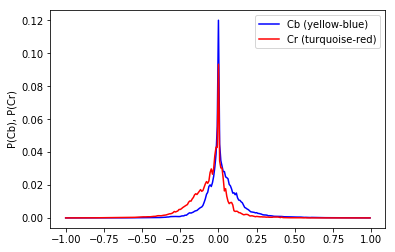

In [78]:
color = ('blue','red')
for i,col in enumerate(color):
    histr = batch_hist(ycbcr_s, i+1)
    #print(histr)
    histr /= pixel_count
    plt.plot(np.arange(-1, 1, 2/256), histr, color = col)
    #plt.xlim([-1,1])
    
plt.ylabel('P(Cb), P(Cr)')
plt.legend(['Cb (yellow-blue)', 'Cr (turquoise-red)'])
plt.savefig('histogram_YCbCr.png', dpi=144)
plt.show()

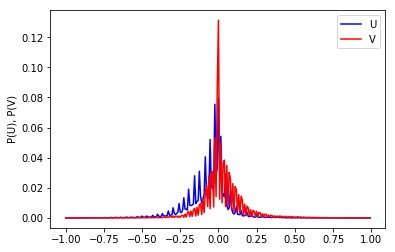

In [79]:
color = ('blue','red')
for i,col in enumerate(color):
    histr = batch_hist(yuv_s, i+1)
    #print(histr)
    histr /= pixel_count
    plt.plot(np.arange(-1, 1, 2/256), histr, color = col)
    #plt.xlim([-1,1])
    
plt.ylabel('P(U), P(V)')
plt.legend(['U', 'V'])
plt.savefig('histogram_YUV.png', dpi=144)
plt.show()